# Sentiment analsysis based on lexical dictionaries

This code allows you to perform Lexicon-Based Sentiment analysis. Based on an original work in https://github.com/jvas28/sentec 
using ecuatorian lexicon, the corpus has been updated with specific bag/good expressions determined by OFFCORSS surveys. Likewise, lexicon is been complemented using the englist-to-spanish translation of the SentiWordNet v3.0.0 (1 June 2010) dataset (https://github.com/aesuli/SentiWordNet).

- For the SentiWordNet dataset, the sentiment score is determined by computing PosScore	- NegScore. (This number is determined between -1 and 1, where -1 is categorized as mostly bad and 1 mostly good)

- For the custom lexicon, the sentiment score has been given in a 1-5 scale, where 1 is categorized as mostly bad and 5 mostly good. Then, the score is standarized to be in the interval [-1, 1] to be conststent with the SentiWordNet dataset

- A working lexicon is created from these two datasets. Only one instance is kept from any repeadted word maintaining the last instance in the dataset. 


The commments are tokenized, and stopwords removed form the lists. The unigrams, bigrams and trigrams and then scored based on the joined lexicon. For words not located in the lexicon, a score of 0 is assigned

The features computed were: the mean score of tokens, the total sum of tokens, the total length of the comment, the maximum score for the tokens in the comment. 

Finally, we tried four classifiers to predict the probability to be in a specific class (bad/good). The ROC curves were finally conmpared


---

## Import packages

In [307]:
# Load packages
import nltk # imports the natural language toolkit
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import string
import re
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from pylab import rcParams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import nltk
from wordcloud import WordCloud
import os
from   scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab
import math 
import sklearn

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sapmn3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sapmn3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [308]:
from data_exploring.data_exploring_functions import *


This code below is based on functions from from https://github.com/jvas28/sentec 

In [309]:
# code from https://github.com/jvas28/sentec 
#           Sentec - Análisis de Sentimiento en Ecuador

#from sentec.src import es_nlp as lang_tools ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
# Using the code directly:

import nltk  
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.stem import SnowballStemmer  
from string import punctuation  
stopwords=stopwords.words('spanish')
# inicializar el extractor de raices lexicales
stemmer = SnowballStemmer('spanish')
# inicializar la lista de palabras ignoradas 
non_words = list(punctuation)  
# agregar a la lista los signos de apertura y los digitos [1-9]
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

# funcion de extraccion de raices lexicales
def stem(word):
    return stemmer.stem(word)

# funcion de extraccion de raices lexicales sobre una lista
def stem_tokens(tokens):  
    stemmed = []
    for item in tokens:
        stemmed.append(stem(item))
    return stemmed

# funcion de disgregacion de palabras 
'''
    Separa las palabras y construye expresiones multipalabras
'''
def tokenize(text):  
    qgrams=[];
    trigrams=[];
    bigrams=[];
    text=text.lower()
    text = ''.join([c for c in text if c not in non_words])
    unigrams =  word_tokenize(text)
    #tokens = [t for t in tokens if t not in stopwords]
    if len(unigrams)>1:
        bigrams=[ x.lower()+" "+y.lower() for (x,y) in zip(unigrams,unigrams[1:])]
    if len(unigrams)>2:
        trigrams=[ x.lower()+" "+y.lower() for (x,y) in zip(bigrams,unigrams[2:])]
    if len(unigrams)>3:
        qgrams=[ x.lower()+" "+y.lower() for (x,y) in zip(trigrams,unigrams[3:])]
    tokens=qgrams+trigrams+bigrams+unigrams
    tokens = stem_tokens(tokens)
    return tokens

#from sentec.src ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#from sentec.src.classifier import nbclassifier,known_words,extract_feature
# Using the code directly:

import nltk
import pickle
import os
# Del modulo creado en la Parte I del microcurso importamos la funcion stem
#from es_nlp import stem
#from sentec.src import es_nlp as stem

# Declaramos las las rutas de los archivos de lexico y clasificador
classifier_file="./sentec/res/train/classifier.pickle"
lexicon_file="./sentec/res/lexicon/sdal_lexicon.csv"


# funcion para extraer caracteristicas para el clasificador
#def extract_feature(w):
#    return {"word":w}

# funcion que construye el set para entrenamiento del algoritmo clasificador
# lexico para el entrenamiento
#lexicon_lines=open(lexicon_file,"r", encoding='utf-8').readlines();
#labeled_words=[]
#known_words=[]
#for line in lexicon_lines:
#    split=line.replace("\n","").split(";")
#    word=split[0].split("_")
#    word=stem(word[0])
#    known_words.append(word)
#    labeled_words.append((word,split[1]))
#feature_set=[(extract_feature(n), sentiment) for (n, sentiment) in labeled_words]

# Para evitar crear y entrenar el clasificador una y otra vez
# usamos pickle para grabar el objeto entrenado como archivo binario
#if not (os.path.isfile(classifier_file)):
#    nbclassifier = nltk.NaiveBayesClassifier.train(feature_set)
#    f = open(classifier_file, 'wb')
#    pickle.dump(nbclassifier, f)
#    f.close();
#else:
#    f = open(classifier_file, 'rb')
#    nbclassifier = pickle.load(f)
#    f.close()

In [310]:
# Define functions for text processing
from sklearn.feature_extraction.text import CountVectorizer
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

# stop words should be updated to accept important words in our context (mostly for bigrams and trigrams)
nostopwords  = ['no','muy','pero','eso']
stopWords_ls = stopwords.words("spanish")
stopWords_ls = [word for word in stopWords_ls if word not in nostopwords]

def words_to_ngrams(words, n, sep=" "):
    ngrams = [sep.join(words[i:i+n]) for i in range(len(words)-n+1)]
    return  ngrams

def get_unique_tokens(comment_ls):

    words_ls = []
    
    for text in comment_ls:
        text  = " ".join(re.findall("[a-zA-Z]+", text))
        words =  word_tokenize(text)
        words = [word for word in words if word not in stopWords_ls]
        
        words_ls.append(list(set(words)))
        
    words_ls = [item for sublist in words_ls for item in sublist]    
     
    return list(set(words_ls))

def get_tokenized(text):
    words =  word_tokenize(text)
    #words = [str.strip(word) for word in words if word not in stopWords_ls]
    words = [str.strip(word) for word in words if word not in stopWords_ls]
    #word = re.compile('\w+').findall(word)
    # get ngrams
    ugrams = words_to_ngrams(words,1)
    bgrams = words_to_ngrams(words,2)
    tgrams = words_to_ngrams(words,3)
    
    ngrams = [ugrams,bgrams,tgrams]
    
    return  [item for sublist in ngrams for item in sublist]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sapmn3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [311]:
# Define features for classification
def get_comment_features(test_comment):

    test_comment = test_comment.replace(" . ", " ").replace(" , ", " ").replace(" .", "")

    tokens = get_tokenized(test_comment)
    #print(test_comment)
    tokens = stem_tokens(tokens)

    elem_scores = []
    scores_vals = []

    for cur_word in tokens:
        if cur_word in known_words['stem'].values:
            element  = known_words[known_words['stem'] == cur_word]
            cur_score = element.score.values[0] 
        else:
            cur_score = 0

        elem_scores.append((cur_word,cur_score))
        scores_vals.append(cur_score)

    if len(scores_vals) > 0 :   
        features_comment = [sum(scores_vals) / len(scores_vals),sum(scores_vals),len(scores_vals), min(scores_vals), max(scores_vals)]
    else:
        features_comment = [0,0,0,0,0]
        
    #print(features_comment)
    #elem_scores
    
    return features_comment

Define functions for training and test of classifiers:

In [312]:
# generate cross-validated ROC and AUC for logistic regression model

from sklearn import ensemble, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from statsmodels.formula.api import ols
from sklearn.naive_bayes import GaussianNB, MultinomialNB

def cv_roc_logit(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        logit = sm.Logit(y.iloc[train].astype('float64'), X.iloc[train].astype('float64'))
        logit_res = logit.fit(disp=0)
        probas_ = logit_res.predict(X.iloc[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

def cv_roc_nb(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        
        gnb = GaussianNB()
        gnb.fit( X.iloc[train].astype('float64'), y.iloc[train].astype('float64'))
        probas_ = gnb.predict_proba(X.iloc[test])
        
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

def cv_roc_rf(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        
        
        clf  = ensemble.RandomForestClassifier(n_estimators = 250)
        clf  = clf.fit(X.iloc[train].astype('float64'), y.iloc[train].astype('float64'))
        probas_ = clf.predict_proba(X.iloc[test])
                
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

def cv_roc_svm(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    

    for train, test in cv.split(X, y):
        
        
        clf = svm.SVC(kernel='linear', probability=True,
                      random_state = 0)
        clf.fit(X.iloc[train].astype('float64'), y.iloc[train].astype('float64'))
        
        probas_ = clf.predict_proba(X.iloc[test])
                
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

----

## Load data:

In [313]:
# Load preprocessed data from surveys
base_datapath = 'C:\\Users\\sapmn3\\Database\\OFFCORSS\\data\\data_clean'

load_file = 'offcorss_sentiment'
load_path = os.path.join(base_datapath, load_file + '.csv')
data_responses = pd.read_csv(load_path)
data_responses = data_responses.drop(columns=['Unnamed: 0'])
data_responses.head()

,Requester,User Id,Email,Ticket Id,Brand,Group,Assignee,Satisfaction,Comment,Survey Date,processed comment
0,alejo.datenshi,374298422771,alejo.datenshi@gmail.com,416857,OFFCORSS,Call Center,VENTAS TIENDA VIRTUAL,good,NaN,2019-01-01,NaN
1,Carime Suarez,1871267083,luzkarinasuarez1980@hotmail.com,421812,OFFCORSS,Tienda Virtual,Servicio al cliente TV,good,NaN,2019-01-01,NaN
2,marketsevenstar,374852675191,marketsevenstar@gmail.com,421796,OFFCORSS,Tienda Virtual,Servicio al cliente TV,bad,ya no deseo hacer el pedido \r\nes la tercera ...,2019-01-01,ya no deseo hacer el pedido es la tercera vez ...
3,Paola Bermudez Motoa,374404056191,paolabermudezmotoa@gmail.com,418196,OFFCORSS,Call Center,Call Center,bad,Me perdieron como cliente pesimo servicio al c...,2019-01-01,me perdieron como cliente pésimo servicio al c...
4,Devolución de producto,7576067323,tmargarita-01@hotmail.com,417254,OFFCORSS,Call Center,VENTAS TIENDA VIRTUAL,good,"Muy buena calidad, soporte y atencion al clie...",2019-01-02,"muy buena calidad , soporte y atencion al clie..."


In [314]:
# Load SentiWordNet words

data_sentiment = pd.read_csv('SentiWordNet.csv', sep='\t')
data_sentiment = data_sentiment[(data_sentiment['PosScore'] > 0) | (data_sentiment['NegScore'] > 0) ].reset_index(drop=True)
data_sentiment.head()

,POS,ID,PosScore,NegScore,SynsetTerms,Gloss
0,a,1740,0.125,0.00,able#1,(usually followed by `to') having the necessar...
1,a,2098,0.000,0.75,unable#1,(usually followed by `to') not having the nece...
2,a,3700,0.250,0.00,dissilient#1,"bursting open with force, as do some ripe seed..."
3,a,3829,0.250,0.00,parturient#2,"giving birth; ""a parturient heifer"""
4,a,5107,0.500,0.00,uncut#7 full-length#2,"complete; ""the full-length play"""


In [315]:
# Load translated SentiWordNet words
spanish_words = pd.read_csv('words_to_translateEN ES.csv', sep=',')
spanish_words = spanish_words.reset_index(drop =True)
#known_words = known_words.drop_duplicates(subset = ['word'], keep = 'last').reset_index(drop = True)
spanish_words.head()

,id,Translation
0,0,capaz.
1,1,incapaz.
2,2,disidente.
3,3,parturiente.
4,4,"sin cortar, de cuerpo entero."


In [316]:
# Select only translated SentiWordNet words and slplit lists 
section_words = data_sentiment.iloc[0:len(spanish_words)]
data_words  = section_words.join(spanish_words)

score_ls = []
words_ls = []

for idx in range(0,len(data_words)):

    text  = spanish_words.iloc[idx,1]
    score = data_sentiment.iloc[idx].PosScore - data_sentiment.iloc[idx].NegScore

    words = text.split(",")

    for word in words:
        word = re.compile('\w+').findall(word)

        if len(word) == 0:
            continue

        words_ls.append(str.lower(word[0]))
        score_ls.append(score)
    

sentWords = pd.DataFrame({'word':words_ls,'score':score_ls,})

sentWords = sentWords.drop_duplicates(subset = ['word'], keep = 'last').reset_index(drop = True)
sentWords.head()

,word,score
0,parturiente,0.250
1,comparativo,-0.250
2,sorbefaciente,0.375
3,asimilado,-0.750
4,quimiorresistente,-0.250


In [317]:
# Load known words from lexical corpus
lex_words = pd.read_csv(lexicon_file, sep=';')
lex_words = lex_words.drop_duplicates(subset = ['word'], keep = 'last').reset_index(drop = True)

# Standarize word score
lex_words['score'] = ((lex_words['score'] - 3)/ 2)
lex_words.head()

,word,score
0,placer,1.0
1,chéverisimo,1.0
2,guayaco,1.0
3,pro,1.0
4,profesional,1.0


Then, the SentiWordNet words and lexical known words are then concatenated:

In [318]:
known_words = pd.concat([sentWords,lex_words]).reset_index(drop = True)
known_words = known_words.drop_duplicates(subset = ['word'], keep = 'last').reset_index(drop = True)
known_words['stem'] = stem_tokens(known_words['word'])
known_words.head()

,word,score,stem
0,parturiente,0.250,parturient
1,comparativo,-0.250,compar
2,sorbefaciente,0.375,sorbefacient
3,asimilado,-0.750,asimil
4,quimiorresistente,-0.250,quimiorresistent


A brief description of distriutions for word scores:

The total of nonrepeated known words is:  7574


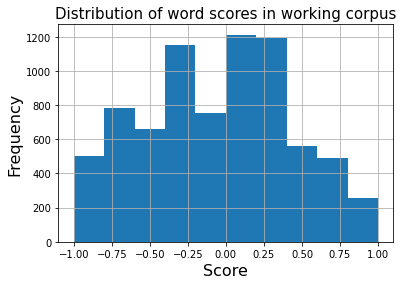

In [319]:
known_words['score'].hist();

plt.title('Distribution of word scores in working corpus', fontsize=15);
plt.xlabel('Score', fontsize=16);
plt.ylabel('Frequency', fontsize=16);

print('The total of nonrepeated known words is: ',str(len(known_words)))

---

Prepare and process data from survey responses. This section may help to identify important unigrams, bigrams and trigrams to include in the lexical corpus

In [320]:
# remove NaN values as empty values
data_responses = data_responses[pd.notna(data_responses['processed comment'])]


In [321]:
# Select comments by classification
satisfaction_good = data_responses[(data_responses['Satisfaction'] == 'good')].reset_index(drop = True)
satisfaction_bad = data_responses[(data_responses['Satisfaction'] == 'bad')].reset_index(drop = True)


In [322]:
# Get tokens by classification
#words =  word_tokenize(satisfaction_good)
#words =  word_tokenize()
word_series = satisfaction_good['processed comment'].reset_index(drop =True)
words_good  = get_unique_tokens(word_series)
word_series = satisfaction_bad['processed comment'].reset_index(drop =True)
words_bad   = get_unique_tokens(word_series)

words_only_bad  = [word for word in words_bad if word not in words_good]
words_only_good = [word for word in words_good if word not in words_bad]

In [323]:
unigrams_good = get_top_n_words(satisfaction_good['processed comment'], 150,1)
bigrams_good  = get_top_n_words(satisfaction_good['processed comment'], 150,2)
trigrams_good = get_top_n_words(satisfaction_good['processed comment'], 150,3)

unigrams_bad  = get_top_n_words(satisfaction_bad['processed comment'], 150,1)
bigrams_bad   = get_top_n_words(satisfaction_bad['processed comment'], 150,2)
trigrams_bad  = get_top_n_words(satisfaction_bad['processed comment'], 150,3)



unigrams_good = [word[0] for word in unigrams_good]
bigrams_good  = [word[0] for word in bigrams_good]
trigrams_good = [word[0] for word in trigrams_good]

unigrams_bad = [word[0] for word in unigrams_bad]
bigrams_bad  = [word[0] for word in bigrams_bad]
trigrams_bad = [word[0] for word in trigrams_bad]


In [324]:
unigrams_keys = [word for word in unigrams_good if word in unigrams_bad]
bigrams_keys  = [word for word in bigrams_good if word in bigrams_bad]
trigrams_keys = [word for word in trigrams_good if word in trigrams_bad]

unigrams_pos = [word for word in unigrams_good if word not in unigrams_bad]
bigrams_pos  = [word for word in bigrams_good if word not in bigrams_bad]
trigrams_pos = [word for word in trigrams_good if word not in trigrams_bad]

unigrams_neg = [word for word in unigrams_bad if word not in unigrams_good]
bigrams_neg  = [word for word in bigrams_bad if word not in bigrams_good]
trigrams_neg = [word for word in trigrams_bad if word not in trigrams_good]

In [325]:
print('Top unigrams_good:')
print(unigrams_pos[:5])
print('Top bigrams_good:')
print(bigrams_pos[:5])
print('Top trigrams_good:')
print(trigrams_pos[:5])

Top unigrams_good:
['excelente', 'bueno', 'buena', 'buen', 'bien']
Top bigrams_good:
['excelente servicio', 'buen servicio', 'buena atención', 'excelente atención', 'mil gracias']
Top trigrams_good:
['servicio muchas gracias', 'excelente muchas gracias', 'excelente servicio gracias', 'buen servicio gracias', 'excelente servicio cliente']


In [326]:
print('Top unigrams_bad:')
print(unigrams_neg[:5])
print('Top bigrams_bad:')
print(bigrams_neg[:5])
print('Top trigrams_bad:')
print(trigrams_neg[:5])

Top unigrams_bad:
['mal', 'dinero', 'malo', 'dirección', 'pésimo']
Top bigrams_bad:
['pésimo servicio', 'mal servicio', 'dado respuesta', 'falta respeto', 'hice pedido']
Top trigrams_bad:
['parece falta respeto', 'nunca recibí respuesta', 'pésimo servicio cliente', 'nunca dieron respuesta', 'mal servicio cliente']


After a careful selection, some of these tokens can be included in the lexical dataset and scores according to the sentiment that they represent

---

## Feature selection

Now we extract the features of comments

In [327]:
data_responses = data_responses.reset_index(drop = True)

vt_comment = []
vt_mean    = []
vt_sum     = []
vt_size    = []
vt_min     = []
vt_max     = []
vt_sentim  = []

nm_lenData = len(data_responses)

for idx in range(0,nm_lenData):
    cur_sent = data_responses.loc[idx,['Satisfaction']].values[0]
    cur_comm = data_responses.loc[idx,['processed comment']].values[0]
    
    features_comment = get_comment_features(cur_comm)
    
    nm_mean = features_comment[0]
    nm_sum  = features_comment[1]
    nm_size = features_comment[2]
    nm_min  = features_comment[3]
    nm_max  = features_comment[4]
    
    vt_comment.append(cur_comm)
    vt_mean.append(nm_mean)
    vt_sum.append(nm_sum)
    vt_size.append(nm_size)
    vt_min.append(nm_min)
    vt_max.append(nm_max)
    vt_sentim.append(cur_sent)
    
features_df = pd.DataFrame({'comment':vt_comment,'mean':vt_mean,'sum':vt_sum,'size':vt_size,
                            'min':vt_min,'max':vt_max,'sentiment':vt_sentim})

In [328]:
print('Total number of good comments:' +str(sum(features_df['sentiment']=='good')))
print('Total number of bad comments:' +str(sum(features_df['sentiment']=='bad')))

features_df


Total number of good comments:6980
Total number of bad comments:3397


,comment,mean,sum,size,min,max,sentiment
0,ya no deseo hacer el pedido es la tercera vez ...,-0.031250,-1.875,60,-1.000,0.375,bad
1,me perdieron como cliente pésimo servicio al c...,-0.229167,-2.750,12,-1.000,0.000,bad
2,"muy buena calidad , soporte y atencion al clie...",0.243056,4.375,18,-0.625,1.000,good
3,no he podido iniciar a trabajar por q no ha si...,-0.036458,-0.875,24,-1.000,0.125,bad
4,hay veces cuelgan pero no son todos hay asesor...,0.013889,0.375,27,-0.625,0.500,good
...,...,...,...,...,...,...,...
10372,"estoy inconforme porque offcorss , omitió mi r...",-0.028846,-1.125,39,-0.750,0.625,bad
10373,la respuesta 5 días después de que llegó el pe...,-0.133333,-2.000,15,-1.000,0.000,bad
10374,me enviaron una talla que no pedi,0.097222,0.875,9,0.000,0.750,bad
10375,que al momento de la cancelación del pedido se...,0.032738,1.375,42,-0.375,0.625,good


Plot distribution of features by class

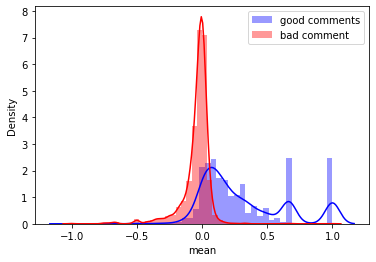

In [329]:
import seaborn as sns
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

sns.distplot( features_df["mean"][features_df["sentiment"] == 'good'] , color="blue", label="good comments")
sns.distplot( features_df["mean"][features_df["sentiment"] == 'bad'] , color="red", label="bad comment")
plt.legend();


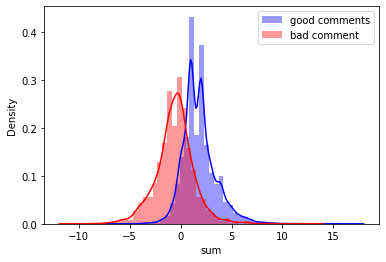

In [330]:
import seaborn as sns

sns.distplot( features_df["sum"][features_df["sentiment"] == 'good'] , color="blue", label="good comments")
sns.distplot( features_df["sum"][features_df["sentiment"] == 'bad'] , color="red", label="bad comment")
plt.legend();

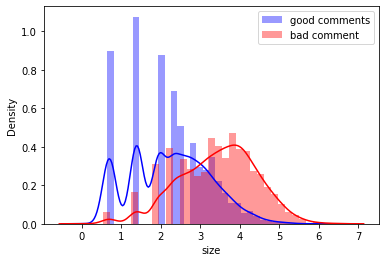

In [331]:
sns.distplot( np.log(features_df["size"][features_df["sentiment"] == 'good']+1) , color="blue", label="good comments")
sns.distplot( np.log(features_df["size"][features_df["sentiment"] == 'bad']+1) , color="red", label="bad comment")
plt.legend();


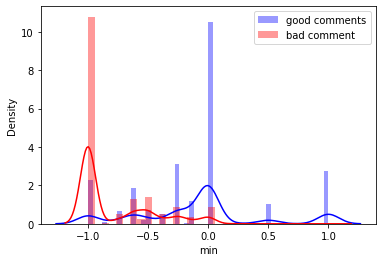

In [332]:
sns.distplot( features_df["min"][features_df["sentiment"] == 'good'] , color="blue", label="good comments")
sns.distplot( features_df["min"][features_df["sentiment"] == 'bad'] , color="red", label="bad comment")
plt.legend();


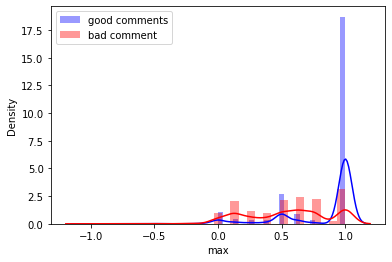

In [333]:
sns.distplot( features_df["max"][features_df["sentiment"] == 'good'] , color="blue", label="good comments")
sns.distplot( features_df["max"][features_df["sentiment"] == 'bad'] , color="red", label="bad comment")
plt.legend();

Determine feature's correlations 

In [334]:
features_df.corr()

,mean,sum,size,min,max
mean,1.000000,0.417731,-0.336313,0.837888,0.552568
sum,0.417731,1.000000,-0.116615,0.392260,0.568268
size,-0.336313,-0.116615,1.000000,-0.479259,0.071318
min,0.837888,0.392260,-0.479259,1.000000,0.313002
max,0.552568,0.568268,0.071318,0.313002,1.000000


Visualizing class distributions by paired features

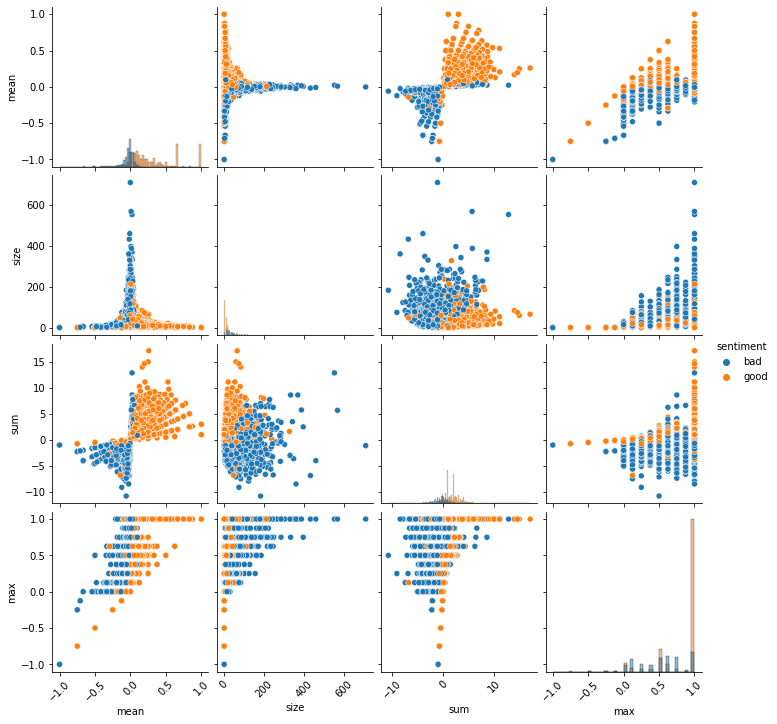

In [335]:
g = sns.pairplot(features_df[["mean", "size", "sum", "max", "sentiment"]], hue="sentiment", diag_kind="hist")
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

There is a class unbalance which is detrimental for training. 

 - Total number of good comments: 6980
 - Total number of bad comments: 3397

Therefore, we can create a subsampling of good comments:  

In [336]:
feat_bad  = features_df[features_df["sentiment"] == 'bad']
feat_good = features_df[features_df["sentiment"] == 'good']
feat_good_sub = feat_good.sample(n = len(feat_bad)).reset_index(drop = True) 
feat_equal= pd.concat([feat_bad,feat_good_sub]).reset_index(drop = True)

print('Total number of instances for classification: '+str(len(feat_equal)))

Total number of instances for classification: 6794


We can visualize that subsampling is not detrimental for class distributions:

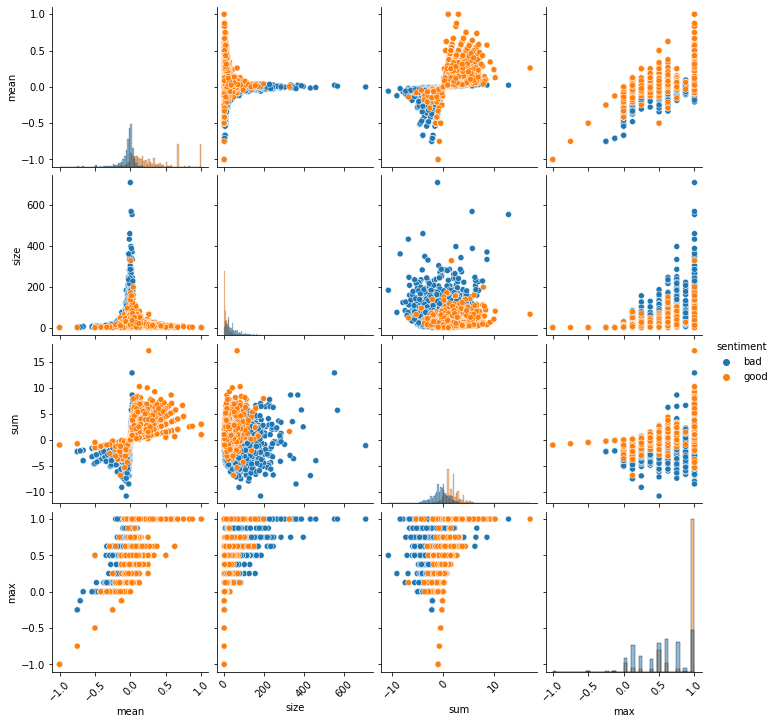

In [337]:
g = sns.pairplot(feat_equal[["mean", "size", "sum", "max", "sentiment"]], hue="sentiment", diag_kind="hist")
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

---

# Model selection

In [338]:
feat_equal

,comment,mean,sum,size,min,max,sentiment
0,ya no deseo hacer el pedido es la tercera vez ...,-0.031250,-1.875,60,-1.000,0.375,bad
1,me perdieron como cliente pésimo servicio al c...,-0.229167,-2.750,12,-1.000,0.000,bad
2,no he podido iniciar a trabajar por q no ha si...,-0.036458,-0.875,24,-1.000,0.125,bad
3,pésimo me quedé esperando esperando y lo peor ...,0.000000,0.000,45,-1.000,0.750,bad
4,"es una falta de respecto y de seriedad , no en...",0.005208,0.250,48,-1.000,0.625,bad
...,...,...,...,...,...,...,...
6789,excelente respuesta ! ! ! muy rapida !,0.119048,2.500,21,0.000,1.000,good
6790,me gusta la atención al cliente que ofrecen us...,0.024306,0.875,36,-0.625,1.000,good
6791,excelente,1.000000,1.000,1,1.000,1.000,good
6792,bueno,1.000000,1.000,1,1.000,1.000,good


### Training of a logit model & cross-validation:

In [339]:
 # Create a logit model
logit_df = feat_equal.copy()
logit_df['Intercept'] = 1.0

logit_df["sentiment"] = logit_df["sentiment"].astype('category')
logit_df["size"] = logit_df["size"].astype('float64')


logit_mdl = sm.Logit(logit_df['sentiment'].cat.codes, logit_df[['Intercept',"mean", "size", "sum", "max"]])

logit_res = logit_mdl.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.316602
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6794
Model:                          Logit   Df Residuals:                     6789
Method:                           MLE   Df Model:                            4
Date:                Fri, 23 Oct 2020   Pseudo R-squ.:                  0.5432
Time:                        18:24:36   Log-Likelihood:                -2151.0
converged:                       True   LL-Null:                       -4709.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0159      0.085      0.188      0.851      -0.150       0.182
mean           5.7041      0.575      9.927      0.000       4.578       6.830
size          -0.0470      0.002    -20.530      0.000      -0.052      -0.043
sum            0.6821      0.043     16.034      0.000       0.599       0.765
max            0.6489      0.149      4.344      0.000       0.356       0.942
==============================================================================
"""

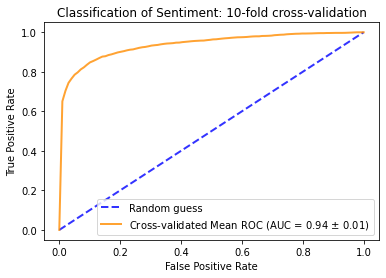

In [340]:
# plot the cross-validated logit ROC

tprs_vs, aucs_vs, mean_fpr_vs = cv_roc_logit(logit_df[['Intercept',"mean", "size", "sum", "max"]], 
                                       logit_df['sentiment'].cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange', lw=2, alpha=.8,
         label=f"Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")

#plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--', lw=line_width,
#         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Sentiment: 10-fold cross-validation')
plt.show()

cv_fpr_logit = mean_fpr_vs 
cv_tpr_logit = mean_tpr_vs
cv_auc_logit = mean_auc_vs
cv_std_logit = std_auc_vs

### Training of a naive-bayes model & cross-validation

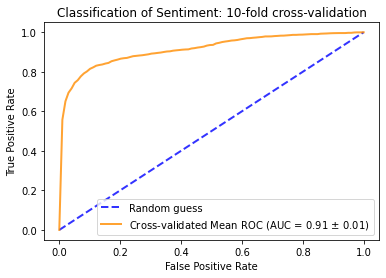

In [341]:
# plot the cross-validated nb ROC

tprs_vs, aucs_vs, mean_fpr_vs = cv_roc_nb(logit_df[['Intercept',"mean", "size", "sum", "max"]], 
                                       logit_df['sentiment'].cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange', lw=2, alpha=.8,
         label=f"Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")

#plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--', lw=line_width,
#         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Sentiment: 10-fold cross-validation')
plt.show()


cv_fpr_nb = mean_fpr_vs 
cv_tpr_nb = mean_tpr_vs
cv_auc_nb = mean_auc_vs
cv_std_nb = std_auc_vs

### Training of a random Forest model & cross-validation

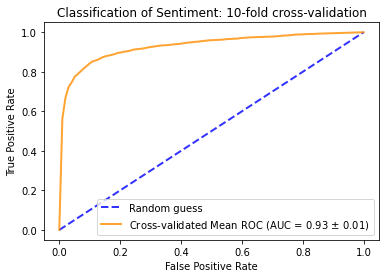

In [342]:
# plot the cross-validated RF ROC

tprs_vs, aucs_vs, mean_fpr_vs = cv_roc_rf(logit_df[['Intercept',"mean", "size", "sum", "max"]], 
                                       logit_df['sentiment'].cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange', lw=2, alpha=.8,
         label=f"Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")

#plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--', lw=line_width,
#         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Sentiment: 10-fold cross-validation')
plt.show()

cv_fpr_rf = mean_fpr_vs 
cv_tpr_rf = mean_tpr_vs
cv_auc_rf = mean_auc_vs
cv_std_rf = std_auc_vs

### Training of a SVM model & cross-validation

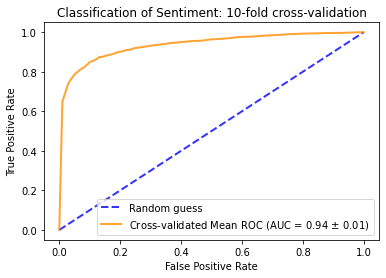

In [343]:
# plot the cross-validated SVM ROC

tprs_vs, aucs_vs, mean_fpr_vs = cv_roc_svm(logit_df[['Intercept',"mean", "size", "sum", "max"]], 
                                       logit_df['sentiment'].cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange', lw=2, alpha=.8,
         label=f"Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")

#plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--', lw=line_width,
#         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Sentiment: 10-fold cross-validation')
plt.show()

cv_fpr_svm = mean_fpr_vs 
cv_tpr_svm = mean_tpr_vs
cv_auc_svm = mean_auc_vs
cv_std_svm = std_auc_vs

### Comparing the models AUCs

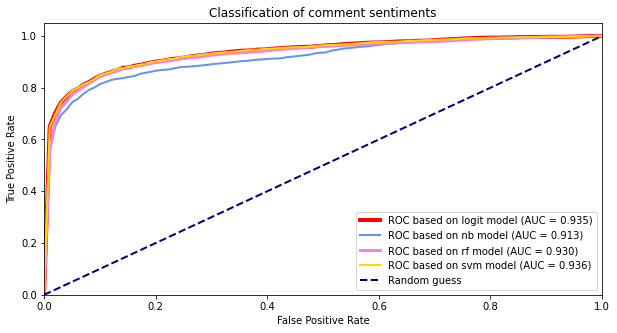

In [344]:
#Plot the ROC curve: (Based in case_9.1)

line_width = 2
plt.figure(figsize=(10,5))
plt.plot(cv_fpr_logit, cv_tpr_logit, color='red', lw=4,
         label=f"ROC based on logit model (AUC = {cv_auc_logit:0.3f})")
plt.plot(cv_fpr_nb, cv_tpr_nb, color='cornflowerblue', lw=line_width,
         label=f"ROC based on nb model (AUC = {cv_auc_nb:0.3f})")
plt.plot(cv_fpr_rf, cv_tpr_rf, color='violet', lw=3,
         label=f"ROC based on rf model (AUC = {cv_auc_rf:0.3f})")
plt.plot(cv_fpr_svm, cv_tpr_svm, color='gold', lw=line_width,
         label=f"ROC based on svm model (AUC = {cv_auc_svm:0.3f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of comment sentiments')
plt.legend(loc='lower right')
plt.show()

---

## Training - testing the algorithm with selected method  

Two algorithms present similar AUC. These are Logit and SVM. Nevertheless, SVM takes longer for training. Hence, we are going to implement the logit model for prediction 

[0.48484848]


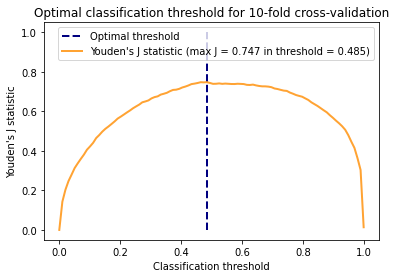

In [345]:
# determine the Youden's stat for better select the optimal threshold of classification

# DEFINE FUNCTION :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def cv_roc_youden(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    youd = []
    aucs = []
    
    threshold = np.linspace(0, 1, 100)
    
    for train, test in cv.split(X, y):
        logit = sm.Logit(y.iloc[train].astype('float64'), X.iloc[train].astype('float64'))
        logit_res = logit.fit(disp=0)
        probas_ = logit_res.predict(X.iloc[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
        
        idx = list(np.argsort(thresholds))
        thresholds = thresholds[idx]
        tpr = tpr[idx]
        fpr = fpr[idx]
        
        # interpolate values for thresholds
        int_fpr     = np.interp(threshold, thresholds, fpr)
        int_tpr     = np.interp(threshold, thresholds, tpr)
        youden_idx  = int_tpr + (1 - int_fpr) - 1        
        
        #print(len(youden_idx))
        
        youd.append(youden_idx)
        #tprs[-1][0] = 0.0
        #roc_auc = auc(fpr, tpr)
        #aucs.append(roc_auc)
    
    return youd, threshold


# FIND THE BEST THRESHOLD :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

vt_youden, vt_threshold = cv_roc_youden(logit_df[['Intercept',"mean", "size", "sum", "max"]], 
                                       logit_df['sentiment'].cat.codes, 10)

vt_meanYouden  = np.mean(vt_youden, axis=0)
nm_maxYouden   = max(vt_meanYouden)
nm_idxMax      = [idx for idx, val in enumerate(vt_meanYouden) if val == nm_maxYouden]
nm_maxThres    = vt_threshold[nm_idxMax]
print(nm_maxThres)

plt.plot([nm_maxThres, nm_maxThres], [0, 1], color='navy', lw=line_width, linestyle='--', label='Optimal threshold');

plt.plot(vt_threshold, vt_meanYouden, color= 'darkorange', lw=2, alpha=.8,
         label=f"Youden's J statistic (max J = {nm_maxYouden:0.3f} in threshold = {nm_maxThres[0]:0.3f})");

plt.xlabel('Classification threshold')
plt.ylabel("Youden's J statistic")
plt.legend(loc='upper right')
plt.title('Optimal classification threshold for 10-fold cross-validation')
plt.show()

In [346]:
# Create a trainig-test set to get classifier to use in further evaluations:
logit_features = logit_df.copy()
logit_labels   = logit_df['sentiment'].cat.codes
                          
X_train, X_test, y_train, y_test = train_test_split(logit_features, logit_labels, test_size = 0.33, random_state = 84)

logit_mdl = sm.Logit(y_train.astype('float64'), X_train[['Intercept',"mean", "size", "sum", "max"]].astype('float64'))
logit_fit = logit_mdl.fit(disp=0)
logit_prob= logit_fit.predict(X_test[['Intercept',"mean", "size", "sum", "max"]])
logit_y   = (logit_prob > nm_maxThres[0]).astype('int8')
        

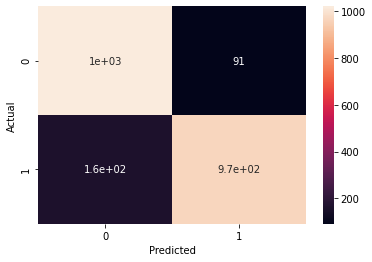

In [347]:

data_predicted = {'y_Actual':    y_test,
                  'y_Predicted': logit_y
                 }

df = pd.DataFrame(data_predicted, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

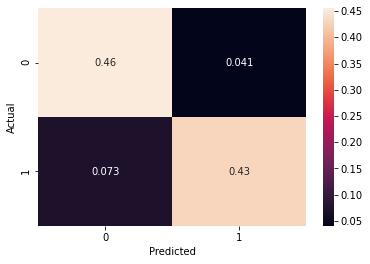

In [348]:

data_predicted = {'y_Actual':    y_test,
                  'y_Predicted': logit_y
                 }

df = pd.DataFrame(data_predicted, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'],
                               rownames = ['Actual'], colnames = ['Predicted'],
                               normalize = True)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [352]:
test_mcc = sklearn.metrics.matthews_corrcoef(y_test, logit_y)
print(sklearn.metrics.classification_report(y_test, logit_y))
print(f'MCC score: {test_mcc:0.3f}')

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1112
           1       0.91      0.86      0.88      1131

    accuracy                           0.89      2243
   macro avg       0.89      0.89      0.89      2243
weighted avg       0.89      0.89      0.89      2243

MCC score: 0.775


---

Let's check the comments that were no well classified:

In [388]:
comments_FN = X_test[(y_test == 1) & (logit_y == 0)]
comments_FP = X_test[(y_test == 0) & (logit_y == 1)]

In [389]:
# Print example comments for false ositive and false negatives
import random

print('False positive examples: \n')

rnd_idx = random.sample(range(0, len(comments_FP)), 5)
rnd_idx

for idx in rnd_idx:
    
    print('New comment:')
    print('\t'+comments_FP['comment'].values[idx])
    print('\n')
    

print('False negative examples: \n')

rnd_idx = random.sample(range(0, len(comments_FN)), 5)
rnd_idx

for idx in rnd_idx:
    
    print('New comment:')
    print('\t'+comments_FN['comment'].values[idx])
    print('\n')
    

False positive examples: 

New comment:
	la chica solo quería terminar la llamada sin que me quedaran clara muchas cosas


New comment:
	quería hacer un regalo a una niña y las tallas que pedí en ninguna prenda aceptaron . no hay control en eso


New comment:
	me gustaría decírselo telefónicamente a la persona encargada de la logística de ventas online


New comment:
	devolvía una compra , envíe un mensaje y ni siquiera me contactaron .


New comment:
	la calidad del producto es muy buena lo que no me gustó fue q me llegó en una talla demasiado pequeña me la mandaron prematuro y yo la había pedido talla de 0-3


False negative examples: 

New comment:
	pude solucionar la devolución y me llegó a tiempo las nuevas prendas


New comment:
	en la linea telefónica 540 51 00 ext . 441 ; 248 ; 178 contabilidad nunca tuve respuesta , y aunque en el correo de servicio al siente no me pudieron brindar el contacto que necesitaba si conté con respuesta casi inmediata .


New comment:
	el tiempo en 

---

## Test classifier in nps surveys

In [355]:
# Load preprocessed data from surveys
base_datapath = 'C:\\Users\\sapmn3\\Database\\OFFCORSS\\data\\data_clean'

load_file = 'offcorss_NPS_surveys'
load_path = os.path.join(base_datapath, load_file + '.csv')
data_nps = pd.read_csv(load_path)
data_nps = data_nps.drop(columns=['Unnamed: 0'])
data_nps.head()

,Survey Date,Name,User Id,Email,Rating,Classification,Comment,Response Date,processed comment,Satisfaction
0,2020-08-10,Johanna Vargas T,4.008424e+11,vhannyt@gmail.com,7,passive,NaN,2020-08-10 11:38,NaN,NaN
1,2020-08-10,Maria Carolina Parra Rincón,4.009328e+11,mariacarolinaparrar@gmail.com,1,detractor,Atender a las reclamaciones a tiempo para evit...,2020-08-10 11:59,atender a las reclamaciones a tiempo para evit...,bad
2,2020-08-10,Luz Marina González Pulido,4.006469e+11,14a793667beb4637bc67b25241ee1150@ct.vtex.com.br,0,detractor,"No leen con atención, por favor dictar capacit...",2020-08-10 12:11,"no leen con atención , por favor dictar capaci...",bad
3,2020-08-10,Devolución de producto,4.011302e+11,paolaga@gmail.com,3,detractor,Se debe poder hacer cambios en tiends fisicas....,2020-08-10 12:32,se debe poder hacer cambios en tienda fisicas ...,bad
4,2020-08-10,Devolución de producto,4.013074e+11,leonlobozharick@gmail.com,10,promoter,NaN,2020-08-10 12:37,NaN,good


In [356]:
# remove NaN values as empty values
data_nps = data_nps[pd.notna(data_nps['processed comment'])]
data_nps.head()

,Survey Date,Name,User Id,Email,Rating,Classification,Comment,Response Date,processed comment,Satisfaction
1,2020-08-10,Maria Carolina Parra Rincón,4.009328e+11,mariacarolinaparrar@gmail.com,1,detractor,Atender a las reclamaciones a tiempo para evit...,2020-08-10 11:59,atender a las reclamaciones a tiempo para evit...,bad
2,2020-08-10,Luz Marina González Pulido,4.006469e+11,14a793667beb4637bc67b25241ee1150@ct.vtex.com.br,0,detractor,"No leen con atención, por favor dictar capacit...",2020-08-10 12:11,"no leen con atención , por favor dictar capaci...",bad
3,2020-08-10,Devolución de producto,4.011302e+11,paolaga@gmail.com,3,detractor,Se debe poder hacer cambios en tiends fisicas....,2020-08-10 12:32,se debe poder hacer cambios en tienda fisicas ...,bad
5,2020-08-10,Ana Mejia,4.016127e+11,mejiaani@gmail.com,0,detractor,No me ha llegado el pedido y dice que fue envi...,2020-08-10 12:56,no me ha llegado el pedido y dice que fue envi...,bad
6,2020-08-10,MARIA NELLY LLANO CHAVARRO,4.014272e+11,nellita_1990@hotmail.com,10,promoter,Tener excelente presentación y buena actitud y,2020-08-10 13:20,tener excelente presentación y buena actitud y,good


In [358]:
data_nps = data_nps.reset_index(drop = True)

vt_comment = []
vt_mean    = []
vt_sum     = []
vt_size    = []
vt_min     = []
vt_max     = []
vt_sentim  = []

nm_lenData = len(data_nps)

for idx in range(0,nm_lenData):
    cur_sent = data_nps.loc[idx,['Rating']].values[0]
    cur_comm = data_nps.loc[idx,['processed comment']].values[0]
    
    features_comment = get_comment_features(cur_comm)
    
    nm_mean = features_comment[0]
    nm_sum  = features_comment[1]
    nm_size = features_comment[2]
    nm_min  = features_comment[3]
    nm_max  = features_comment[4]
    
    vt_comment.append(cur_comm)
    vt_mean.append(nm_mean)
    vt_sum.append(nm_sum)
    vt_size.append(nm_size)
    vt_min.append(nm_min)
    vt_max.append(nm_max)
    vt_sentim.append(cur_sent)
    
features_nps = pd.DataFrame({'comment':vt_comment,'mean':vt_mean,'sum':vt_sum,'size':vt_size,
                            'min':vt_min,'max':vt_max,'rating':vt_sentim})

In [359]:
features_nps

,comment,mean,sum,size,min,max,rating
0,atender a las reclamaciones a tiempo para evit...,-0.006944,-0.250,36,-1.000,0.625,1
1,"no leen con atención , por favor dictar capaci...",-0.005208,-0.125,24,-0.500,0.375,0
2,se debe poder hacer cambios en tienda fisicas ...,0.020833,1.250,60,-0.250,0.375,3
3,no me ha llegado el pedido y dice que fue envi...,-0.062500,-1.125,18,-1.000,0.750,0
4,tener excelente presentación y buena actitud y,0.135417,1.625,12,-0.375,1.000,10
...,...,...,...,...,...,...,...
2711,promociones,0.000000,0.000,1,0.000,0.000,10
2712,ha superado mis expectativas !,0.041667,0.250,6,-0.375,0.625,10
2713,me gustaría que hubieran mas opciones de jeans...,0.030303,1.000,33,-0.375,0.500,9
2714,mas diseños de tapabocas para niños,0.055556,0.500,9,0.000,0.250,10


In [381]:
logit_nps = features_nps.copy()
logit_nps['Intercept'] = 1.0
logit_nps["size"]      = logit_nps["size"].astype('float64')

logit_nps["log_probability"] = logit_fit.predict(logit_nps[['Intercept',"mean", "size", "sum", "max"]])
logit_nps["predicted_class"] = (logit_nps["log_probability"] > nm_maxThres[0]).astype('int8')
logit_nps["rating_class"]    = (logit_nps["rating"] > 3).astype('int8')
        

In [382]:
logit_nps

,comment,mean,sum,size,min,max,rating,Intercept,log_probability,predicted_class,rating_class
0,atender a las reclamaciones a tiempo para evit...,-0.006944,-0.250,36.0,-1.000,0.625,1,1.0,0.186012,0,0
1,"no leen con atención , por favor dictar capaci...",-0.005208,-0.125,24.0,-0.500,0.375,0,1.0,0.270885,0,0
2,se debe poder hacer cambios en tienda fisicas ...,0.020833,1.250,60.0,-0.250,0.375,3,1.0,0.188581,0,0
3,no me ha llegado el pedido y dice que fue envi...,-0.062500,-1.125,18.0,-1.000,0.750,0,1.0,0.173684,0,0
4,tener excelente presentación y buena actitud y,0.135417,1.625,12.0,-0.375,1.000,10,1.0,0.864221,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2711,promociones,0.000000,0.000,1.0,0.000,0.000,10,1.0,0.481859,0,1
2712,ha superado mis expectativas !,0.041667,0.250,6.0,-0.375,0.625,10,1.0,0.608136,1,1
2713,me gustaría que hubieran mas opciones de jeans...,0.030303,1.000,33.0,-0.375,0.500,9,1.0,0.413909,0,1
2714,mas diseños de tapabocas para niños,0.055556,0.500,9.0,0.000,0.250,10,1.0,0.592736,1,1


In [383]:
logit_nps.corr()

,mean,sum,size,min,max,rating,Intercept,log_probability,predicted_class,rating_class
mean,1.000000,0.317543,-0.316531,0.736081,0.515801,0.250430,NaN,0.697423,0.505582,0.172994
sum,0.317543,1.000000,0.132418,0.170716,0.592788,0.273564,NaN,0.651929,0.531964,0.208541
size,-0.316531,0.132418,1.000000,-0.535951,0.162101,-0.309310,NaN,-0.442047,-0.303252,-0.216592
min,0.736081,0.170716,-0.535951,1.000000,0.137180,0.355688,NaN,0.630884,0.466524,0.267264
max,0.515801,0.592788,0.162101,0.137180,1.000000,0.136956,NaN,0.646941,0.629850,0.095997
rating,0.250430,0.273564,-0.309310,0.355688,0.136956,1.000000,NaN,0.426924,0.343320,0.879296
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_probability,0.697423,0.651929,-0.442047,0.630884,0.646941,0.426924,NaN,1.000000,0.854072,0.313225
predicted_class,0.505582,0.531964,-0.303252,0.466524,0.629850,0.343320,NaN,0.854072,1.000000,0.253675
rating_class,0.172994,0.208541,-0.216592,0.267264,0.095997,0.879296,NaN,0.313225,0.253675,1.000000


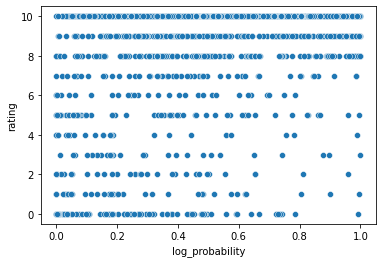

In [373]:
sns.scatterplot(data=logit_nps, x="log_probability", y="rating");

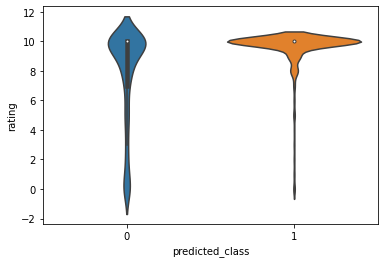

In [379]:
sns.violinplot(data=logit_nps, x="predicted_class", y="rating");

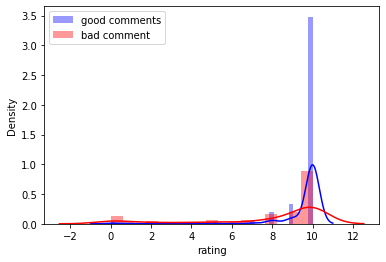

In [380]:
sns.distplot( logit_nps["rating"][logit_nps["predicted_class"] == 1] , color="blue", label="good comments")
sns.distplot( logit_nps["rating"][logit_nps["predicted_class"] == 0] , color="red", label="bad comment")
plt.legend();

In [384]:
test_mcc = sklearn.metrics.matthews_corrcoef(logit_nps['rating_class'], logit_nps['predicted_class'])
print(sklearn.metrics.classification_report(logit_nps['rating_class'], logit_nps['predicted_class']))
print(f'MCC score: {test_mcc:0.3f}')

              precision    recall  f1-score   support

           0       0.15      0.79      0.26       180
           1       0.98      0.69      0.81      2536

    accuracy                           0.70      2716
   macro avg       0.57      0.74      0.54      2716
weighted avg       0.92      0.70      0.78      2716

MCC score: 0.254


In [385]:
nps_comments_FN = logit_nps[(logit_nps['rating_class'] == 1) & (logit_nps['predicted_class'] == 0)]
nps_comments_FP = logit_nps[(logit_nps['rating_class'] == 0) & (logit_nps['predicted_class'] == 1)]

In [387]:
# Print example comments for false ositive and false negatives
import random

print('False positive examples: \n')

rnd_idx = random.sample(range(0, len(nps_comments_FP)), 10)
rnd_idx

for idx in rnd_idx:
    
    print('New comment:')
    print('\t'+nps_comments_FP['comment'].values[idx])
    print('\n')
    

print('False negative examples: \n')

rnd_idx = random.sample(range(0, len(nps_comments_FN)), 10)
rnd_idx

for idx in rnd_idx:
    
    print('New comment:')
    print('\t'+nps_comments_FN['comment'].values[idx])
    print('\n')

False positive examples: 

New comment:
	brindar información con claridad y orientar bien a los clientes


New comment:
	no obligar a los clientes a hacer los cambios por la pagina si no que se le reconozca el derecho de hacer el cambio en cualquier tienda física . las demás marcas y tiendas virtuales permiten que cuando se hace una compra online se puede hacer el cambio en cualquier tienda física esto si es buen servicio al cliente . gracias


New comment:
	mejorar la calidad de los zapatos .


New comment:
	la experiencia de compra por la página es muy complicada , poco amigable , e intentado realizar varias compras pero siempre pierdo las prendas de mi carrito . bien sea por elegir talla o buscar otro producto .


New comment:
	que la ropa que envíen este en buen estado


New comment:
	enviar productos de buena calidad y lo que solicita en la pagina


New comment:
	los zapatos estan imperfectos no quede satisfecha con el pedido


New comment:
	yo orden un producto con un begins de u